<a href="https://colab.research.google.com/github/afr0thunder/brain_tumors/blob/main/brain_tumor_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-class Brain Tumor Classification Using MRI BRain Scan Images

The goal of this notebook is to build a model that can examine MRI brainscan data and predict if the scan is normal or contains a tumor. This not intented for medical diagnosis, but rather to see if rapid screening is possible for MRI data on the brain.

## 1. Define Problem

Idenfity if a brain scan is normal or contains one off three classes of brain tumor.
Possible classes:
* glioma tumor
* meningioma tumor
* pituitary tumor
* no tumor (normal)

## 2. Data
The data was obtained through Kaggle.com. It contains ~3100 images sorted into the four categories listed above.

link: https://www.kaggle.com/datasets/thomasdubail/brain-tumors-256x256/data

3. Evaluation

Evaluated on Multi-class Log Loss between predicted probability and the observed target.

# Prepare Workspace

In [149]:
# Import necessary tools
!pip install keras_tuner

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imread
import datetime
import os
import tensorflow as tf
import keras_tuner as kt
import tensorflow_hub as hub
print ("TF version: ", tf.__version__)
print ("TF Hub version: ", hub.__version__)

# Check for GPU availability
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version:  2.13.0
TF Hub version:  0.15.0
GPU available


# Prepare the data for analysis

The data needs the following:
* A csv file needs to be prepared with pathnames for each image and containing the classifiaction for each image

In [98]:
# Create an array with file names for images and an array with label classifications
filenames = []
labels = []

for image in range(0, len(os.listdir('drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/glioma_tumor/'))):
    filenames.append(f'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/glioma_tumor/G_{image+1}.jpg')
    labels.append('glioma_tumor')
for image in range(0, len(os.listdir('drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/meningioma_tumor/'))):
    filenames.append(f'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/meningioma_tumor/M_{image+1}.jpg')
    labels.append('meningioma_tumor')
for image in range(0, len(os.listdir('drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/normal/'))):
    filenames.append(f'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/normal/N_{image+1}.jpg')
    labels.append('normal')
for image in range(0, len(os.listdir('drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/pituitary_tumor/'))):
    filenames.append(f'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/pituitary_tumor/P_{image+1}.jpg')
    labels.append('pituitary_tumor')

In [99]:
# Check the first 10
filenames[:10]

['drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/glioma_tumor/G_1.jpg',
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/glioma_tumor/G_2.jpg',
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/glioma_tumor/G_3.jpg',
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/glioma_tumor/G_4.jpg',
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/glioma_tumor/G_5.jpg',
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/glioma_tumor/G_6.jpg',
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/glioma_tumor/G_7.jpg',
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/glioma_tumor/G_8.jpg',
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/glioma_tumor/G_9.jpg',
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/glioma_tumor/G_10.jpg']

In [100]:
# Check the first 10
labels[:10]

['glioma_tumor',
 'glioma_tumor',
 'glioma_tumor',
 'glioma_tumor',
 'glioma_tumor',
 'glioma_tumor',
 'glioma_tumor',
 'glioma_tumor',
 'glioma_tumor',
 'glioma_tumor']

In [101]:
# Check whether number of filenames matches number of actual image files
directory_length = len(os.listdir('drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/glioma_tumor/')) + len(os.listdir('drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/meningioma_tumor/')) + len(os.listdir('drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/normal/')) + len(os.listdir('drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/pituitary_tumor/'))

if directory_length == len(filenames):
  print("Filenames length matches # of images")
  print(f'# of images: {directory_length}')
  print(f'Length of filenames: {len(filenames)}')
else:
  print("Filenames length does not match # of images")
  print(f'# of images: {directory_length}')
  print(f'Length of filenames: {len(filenames)}')

# Check whether number of labels matches number of actual image files
if directory_length == len(filenames):
  print("Labels length matches # of images")
  print(f'# of images: {directory_length}')
  print(f'Length of labels: {len(labels)}')
else:
  print("Labels length does not match # of images")
  print(f'# of images: {directory_length}')
  print(f'Length of labels: {len(labels)}')

Filenames length matches # of images
# of images: 3096
Length of filenames: 3096
Labels length matches # of images
# of images: 3096
Length of labels: 3096


In [102]:
# Find the unique label values
diagnosis = np.unique(labels)
len(diagnosis)

4

In [103]:
# Turn every label into a boolean array
boolean_labels = [label == diagnosis for label in labels]
boolean_labels[:3]

[array([ True, False, False, False]),
 array([ True, False, False, False]),
 array([ True, False, False, False])]

In [104]:
# Check if boolean_labels is the same length as # of images
if directory_length == len(boolean_labels):
  print("Boolean_labels length matches # of images")
  print(f'# of images: {directory_length}')
  print(f'Length of boolean_labels: {len(boolean_labels)}')
else:
  print("Boolean_labels length does not match # of images")
  print(f'# of images: {directory_length}')
  print(f'Length of boolean_labels: {len(boolean_labels)}')

Boolean_labels length matches # of images
# of images: 3096
Length of boolean_labels: 3096


In [105]:
# Create dataframe with both arrays
np.random.seed(42)
filenames_np = np.array(filenames)
boolean_labels_np = np.array(boolean_labels)

# shuffle arrays in unison
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

filenames_np_shuffled, boolean_labels_np_shuffled = unison_shuffled_copies(filenames_np, boolean_labels_np)

print(filenames_np_shuffled[:10])
print(boolean_labels_np_shuffled[:10])

['drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/normal/N_134.jpg'
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/meningioma_tumor/M_409.jpg'
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/meningioma_tumor/M_706.jpg'
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/pituitary_tumor/P_375.jpg'
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/pituitary_tumor/P_189.jpg'
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/normal/N_144.jpg'
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/pituitary_tumor/P_472.jpg'
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/glioma_tumor/G_185.jpg'
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/meningioma_tumor/M_360.jpg'
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/glioma_tumor/G_195.jpg']
[[False False  True False]
 [False  True False False]
 [False  True False False]
 [False False False  True]
 [False False False  True]
 [False False  True False]
 [False False Fals

## Create train, validation, and test sets

In [106]:
# Setup X & y variables
X = filenames_np_shuffled
y = boolean_labels_np_shuffled

NUM_IMAGES = 3096

In [107]:
# Split data into train and test/validation sets
X_train, X_test_val, y_train, y_test_val = train_test_split(X[:NUM_IMAGES],
                                                   y[:NUM_IMAGES],
                                                   test_size=0.3,
                                                   random_state=42)

len(X_train), len(y_train), len(X_test_val), len(y_test_val)

(2167, 2167, 929, 929)

In [108]:
# Split test_val into test and validation sets
split = int(round(len(X_test_val)/2))

X_val = X_test_val[:split]
X_test = X_test_val[split:]
y_val = y_test_val[:split]
y_test = y_test_val[split:]

len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test)

(2167, 2167, 464, 464, 465, 465)

## Preprocessing Images (turning images into Tensors)

Going to write a function that:

* Take an image filepath as input
* Use TensorFlow to read the file and save it to a variable image
* Convert color values from 0-255 to 0-1 at the same scale
* Turn our image (a jpg) into Tensors
* Resize the image to be a shape of (256, 256)
* Return the modified image

In [109]:
# Define image size
IMG_SIZE = 256

# Create function to preprocess data
def process_image(image_path):
  """
  Takes an image file path and turn the image into a Tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path)

  # Turn the jpeg image into numerial Tensor with 3 color channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)

  # Convert the color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the image to desired value
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

## Turning our data into batches (32 is standard size)

batch size adjusts for memory available

data needs to be in the form of Tensor tuples which look like this: `(image, label)`

In [110]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label, processes the image and returns a tuple of (image, label)
  """
  image = process_image(image_path)
  return image, label

## Create a function that batches the data for processing

In [111]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs. Shuffles, the data if it's training data, but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels.)
  """
  # If the data is a test dataset, will not have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths(no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # if the data is a validation dataset, will not need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                              tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  # Create training batches
  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor is faster than shuffling later
    data = data.shuffle(buffer_size=len(X))
    # Create (image, label) tuples (this also turn the image path into a preprocessed image)
    data = data.map(get_image_label)
    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [112]:
# Create training and validation data batches
train_data = create_data_batches(X_train,y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)
test_data = create_data_batches(X_test, y_test, valid_data=True)

Creating training data batches...
Creating validation data batches...
Creating validation data batches...


In [113]:
# Check out the different attributes of the data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 4), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 4), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Need to visualize the data as it is difficult to understand

In [114]:
# Create a function for viewing images in a data batch
def show_25_images(image, labels):
  """
  Displays a plot of 25 images and their labels from a data batch
  """
  # Setup the figure
  plt.figure(figsize=(10,10))
  #loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 row, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(image[i])
    # Add the image label as the title
    plt.title(diagnosis[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [115]:
train_images, train_labels = next(train_data.as_numpy_iterator())

len(train_images), len(train_labels)

(32, 32)

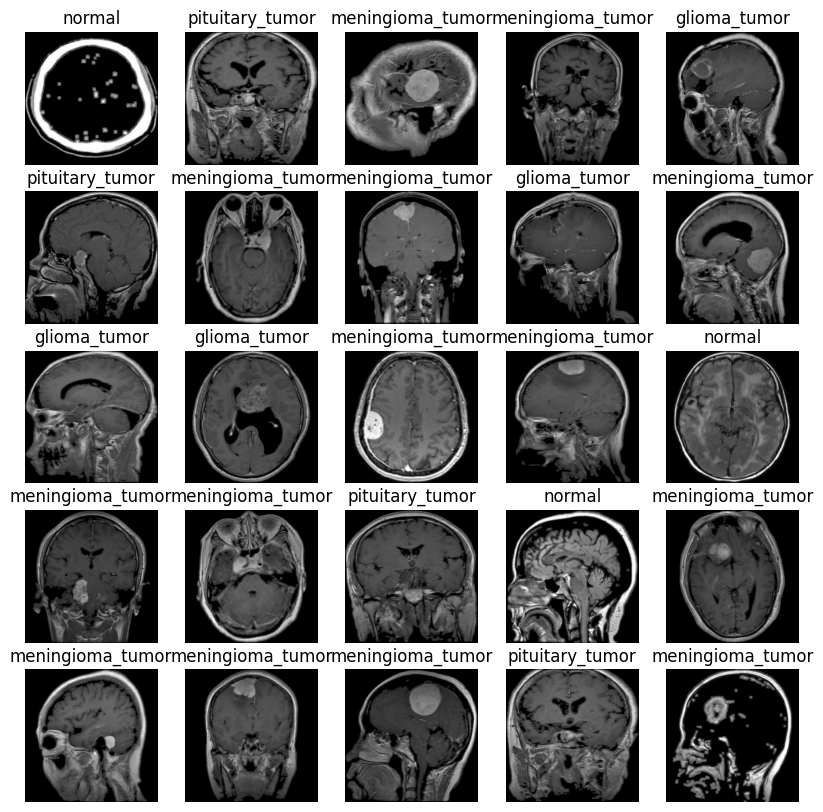

In [116]:
# Visualize the data in a training batch
show_25_images(train_images, train_labels)

## Building a model

Before a model is built, a few things need to be defined:

* The input shape (image shape, in the form of Tensors) to the model.
* The output shape (image labels, in the form of Tensors) of the model.
* The URL of the model we want to use

In [117]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Setup output shape of the model
OUTPUT_SHAPE = len(diagnosis)

# Setup model URL from TensorFlow Hub
MODEL_URL = 'https://tfhub.dev/google/imagenet/resnet_v2_152/classification/5'

Now there are inputs, outputs and model ready to go, combine them together into a Kera deep learning model.

Need to create a function which:
* Takes the input shape, outputs shape and the model chosen as paramters.
* Defines the layers in a Keras model in sequential fashion (do this first, then that)
* Compiles the model (says it should be evaluated and improved)
* Builds the model (tells the model the input shape it'll be getting)
* Returns the model

In [118]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with: ", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
      hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
      tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                            activation="softmax") # Layer 2 (output layer)
  ])
  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [ ]:
# Create tuner for tuning the model


In [119]:
model = create_model()
model.summary()

Building model with:  https://tfhub.dev/google/imagenet/resnet_v2_152/classification/5
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 1001)              60382697  
                                                                 
 dense_4 (Dense)             (None, 4)                 4008      
                                                                 
Total params: 60386705 (230.36 MB)
Trainable params: 4008 (15.66 KB)
Non-trainable params: 60382697 (230.34 MB)
_________________________________________________________________


## Creating Callbacks

Callbacks are helper functions a model can use during the training to do such things as save its progress, check its progress or stop training early if a model stops improving

Need to create two callbacks, one for TensorBoard which helps track the models progress and another for early stopping which prevents the model from training for too long.

TensorBoard Callback
To setup a TensorBoard callback, will need to do 3 things:
1. Load the TensorBoard notebook extenstion
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to the model's `fit()` funtion
3. Visualize the models training logs with the `%tensorboard` magic function (we'll do this after model training)

In [120]:
# Load TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [121]:
# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/MyDrive/Google Colab/Data Sets/brain_tumors/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [122]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=5)

## Training the first model

In [123]:
NUM_EPOCHS = 100

# Check to make sure still running on a GPU
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

GPU available


## Let's create a function which trains a model

* Create a model using `create_modl()~
* Setup a TensorBoard callback using `create_tensorboard_callback`
* Call the `fit()` function on the model passing it the training data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks used
* Return the model

In [124]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  #Create a model
  model = create_model()

  # Create new TensorBoard session everytime model is trained
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model

In [125]:
# train the model
model = train_model()

Building model with:  https://tfhub.dev/google/imagenet/resnet_v2_152/classification/5
Epoch 1/100
68/68 [==============================] - 47s 372ms/step - loss: 1.0583 - accuracy: 0.5925 - val_loss: 0.7744 - val_accuracy: 0.6810
Epoch 2/100
68/68 [==============================] - 23s 333ms/step - loss: 0.6120 - accuracy: 0.7596 - val_loss: 0.6557 - val_accuracy: 0.7306
Epoch 3/100
68/68 [==============================] - 22s 329ms/step - loss: 0.5227 - accuracy: 0.8011 - val_loss: 0.6394 - val_accuracy: 0.7565
Epoch 4/100
68/68 [==============================] - 22s 317ms/step - loss: 0.4923 - accuracy: 0.8117 - val_loss: 0.7261 - val_accuracy: 0.7414
Epoch 5/100
68/68 [==============================] - 21s 311ms/step - loss: 0.4549 - accuracy: 0.8200 - val_loss: 0.6056 - val_accuracy: 0.7759
Epoch 6/100
68/68 [==============================] - 22s 316ms/step - loss: 0.4158 - accuracy: 0.8426 - val_loss: 0.5756 - val_accuracy: 0.7823
Epoch 7/100
68/68 [==============================

## Checking the TensorBoard logs

The TensorBoard magic Function (`%tensorboard`) will access the logs directly created earlier and visualize it's contents.

In [126]:
%tensorboard --logdir drive/My\ Drive/Google\ Colab/Data\ Sets/DogVision/logs

Reusing TensorBoard on port 6006 (pid 7742), started 0:29:39 ago. (Use '!kill 7742' to kill it.)

<IPython.core.display.Javascript object>

## Making and evaluating predicitons using a trained model

In [127]:
preds = model.predict(val_data, verbose=1)
preds

15/15 [==============================] - 23s 244ms/step


array([[3.04491608e-03, 6.44961745e-02, 9.32453275e-01, 5.70799784e-06],
       [8.64551842e-01, 1.00483358e-01, 1.24292180e-03, 3.37219052e-02],
       [8.53859961e-01, 1.42605290e-01, 3.52863432e-03, 6.15760746e-06],
       ...,
       [2.09686626e-02, 9.56489921e-01, 2.23832205e-02, 1.58244162e-04],
       [2.06647724e-01, 7.76497841e-01, 1.15271825e-04, 1.67391505e-02],
       [2.17170224e-01, 3.40728492e-01, 6.52331160e-03, 4.35577929e-01]],
      dtype=float32)

In [128]:
preds.shape

(464, 4)

In [129]:
np.sum(preds[0])

1.0000001

In [130]:
# First prediction
index = 0
print(preds[index])
print(f"Max value (probablity of predicition): {np.max(preds[index])}")
print(f"Sum: {np.sum(preds[index])}")
print(f"Max index: {np.argmax(preds[index])}")
print(f"Predicted label: {diagnosis[np.argmax(preds[index])]}")

[3.0449161e-03 6.4496174e-02 9.3245327e-01 5.7079978e-06]
Max value (probablity of predicition): 0.9324532747268677
Sum: 1.0000001192092896
Max index: 2
Predicted label: normal


In [131]:
# Turn prediciton probabilities into thier respective label
def get_pred_label(predicition_probabilities):
  """
  Turns an array of prediciton probabilities into a label.
  """
  return diagnosis[np.argmax(predicition_probabilities)]

# Get a predicted label based on an array of prediciton probabilities
pred_label = get_pred_label(preds[81])
pred_label

'pituitary_tumor'

In [132]:
# Create a function to unbatch a dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(diagnosis[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], dtype=float32),
 'normal')

Now ways have been generated to get:
* Prediciton labels
* Validation labels (truth labels)
* Validation images

Now to make some function to visualize

Create a function which:
* Takes an array of prediction probabilites, an array of truth labels and an array of images and integers.
* Convert the prediciton probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and the target on a single plot.

In [133]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)
  pass

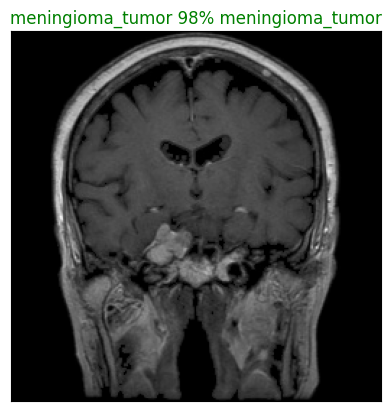

In [134]:
plot_pred(prediction_probabilities=preds,
          labels=val_labels,
          images=val_images,
          n=77)

This function will:
* Take an input of prediction probabilities array and a ground truth array and an integer
* Find the prediction using `get_pred_label()`
* Find the top 10
    * Prediction probability indexes
    * Prediction probability values
    * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green

In [135]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n
  """

  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")


  # Change color of the true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

## Saving and Loading Models

In [136]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/MyDrive/Google Colab/Data Sets/brain_tumors/models/",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [137]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from {model_path}...")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [138]:
# Save our model
save_model(model, suffix=('resnet_v2_152/classification'))

Saving model to: drive/MyDrive/Google Colab/Data Sets/brain_tumors/models/20231014-20281697315335-resnet_v2_152/classification.h5...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'drive/MyDrive/Google Colab/Data Sets/brain_tumors/models/20231014-20281697315335-resnet_v2_152/classification.h5'

In [139]:
# Load a trained model
loaded_model = load_model('/content/drive/MyDrive/Google Colab/Data Sets/brain_tumors/models/20231014-20051697313918-resnet_v2_152/classification.h5')

Loading saved model from /content/drive/MyDrive/Google Colab/Data Sets/brain_tumors/models/20231014-20051697313918-resnet_v2_152/classification.h5...


In [140]:
model.evaluate(val_data)

15/15 [==============================] - 4s 243ms/step - loss: 0.5683 - accuracy: 0.7716


[0.5682725310325623, 0.7715517282485962]

In [145]:
model.evaluate(test_data)

15/15 [==============================] - 1s 52ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]